In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mypackage import Strategy_Manager, Strategy, Backtester, compare_results, strategy, DataFileReader

# Définir le chemin vers vos fichiers de données
filepath = 'fichier_donnée.csv'

# Initialiser le lecteur de fichiers
reader = DataFileReader(date_format='%d/%m/%Y')
data = reader.read_file(filepath, date_column='Date_Price')
data = data[data.columns.to_list()[:10]]
all_asset = data.columns.to_list()

# Création d'une stratégie par héritage

class MovingAverageCrossover(Strategy):
    """Stratégie de croisement de moyennes mobiles pour plusieurs actifs."""
    
    def __init__(self, assets, short_window=20, long_window=50, rebalancing_frequency='D', 
                 allocation_method='equal'):
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.short_window = short_window
        self.long_window = long_window
        self.allocation_method = allocation_method

    def get_position(self, historical_data, current_position):
        if len(historical_data) < self.long_window:
            return {asset: 0 for asset in self.assets}
        
        signals = {}
        for asset in self.assets:
            short_ma = historical_data[asset].rolling(self.short_window).mean()
            long_ma = historical_data[asset].rolling(self.long_window).mean()
            signals[asset] = 1 if short_ma.iloc[-1] > long_ma.iloc[-1] else -1
        
        # Allocation des positions selon la méthode choisie
        if self.allocation_method == 'equal':
            position_size = 1.0 / len(self.assets)
            positions = {asset: signal * position_size for asset, signal in signals.items()}
        else:  # 'signal_weighted'
            total_signals = sum(abs(signal) for signal in signals.values())
            positions = {asset: signal / total_signals for asset, signal in signals.items()}
            
        return positions


# Création d'une stratégie simple avec décorateur
@strategy
def momentum_strategy(historical_data, current_position, assets, rebalancing_frequency, chosen_window=20):
    """
    Calcule un signal de trading basé sur le momentum pour plusieurs actifs.
    
    Args:
        historical_data: DataFrame avec les données historiques
        current_position: Position actuelle
        assets: Liste des actifs
        rebalancing_frequency: Fréquence de rebalancement
        chosen_window: Fenêtre pour le calcul du momentum
    
    Returns:
        dict: Positions pour chaque actif
    """
    if len(historical_data) < chosen_window:
        return {asset: 0 for asset in assets}

    positions = {}
    active_assets = []  # Liste pour suivre les actifs avec un signal valide
    
    for asset in assets:
        try:
            returns = historical_data[asset].pct_change(chosen_window)
            # Vérifier si le dernier rendement est valide
            if pd.isna(returns.iloc[-1]):
                positions[asset] = 0
            else:
                # Signal 1 si momentum positif, -1 si négatif
                signal = 1 if returns.iloc[-1] > 0 else -1
                positions[asset] = signal
                active_assets.append(asset)
        except Exception:
            # En cas d'erreur dans le calcul, position neutre
            positions[asset] = 0
    
    # Ajuster les positions si des actifs actifs existent
    if active_assets:
        allocation_size = 1.0 / len(active_assets)
        for asset in assets:
            if asset in active_assets:
                positions[asset] *= allocation_size
                
    return positions

class VolatilityBasedStrategy(Strategy):
    def __init__(self, assets, volatility_threshold=0.02, window_size=10, rebalancing_frequency='D', allocation_method='equal'):
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.volatility_threshold = volatility_threshold
        self.window_size = window_size
        self.volatility = None
        self.allocation_method = allocation_method

    def fit(self, data: pd.DataFrame) -> None:
        """Calcule la volatilité historique pour chaque actif."""
        self.volatility = {}
        for asset in self.assets:
            daily_returns = data[asset].pct_change()
            self.volatility[asset] = daily_returns.rolling(window=self.window_size).std()

    def get_position(self, historical_data: pd.DataFrame, current_position: dict) -> dict:
        """
        Détermine les positions basées sur la volatilité de chaque actif.
        Une forte volatilité conduit à une position short, une faible volatilité à une position long.
        """
        if self.volatility is None:
            raise ValueError("La méthode fit() doit être appelée avant get_position().")
        
        positions = {}
        active_assets = []
        
        # Déterminer les signaux pour chaque actif
        for asset in self.assets:
            current_vol = self.volatility[asset].iloc[-1]
            
            if current_vol is None or pd.isna(current_vol):
                positions[asset] = 0
            else:
                if current_vol > self.volatility_threshold:
                    positions[asset] = -1
                    active_assets.append(asset)
                else:
                    positions[asset] = 1
                    active_assets.append(asset)
        
        # Ajuster les allocations selon la méthode choisie
        if active_assets:
            if self.allocation_method == 'equal':
                position_size = 1.0 / len(active_assets)
                for asset in active_assets:
                    positions[asset] *= position_size
            else:  # 'volatility_weighted'
                total_vol = sum(self.volatility[asset].iloc[-1] for asset in active_assets)
                for asset in active_assets:
                    weight = self.volatility[asset].iloc[-1] / total_vol
                    positions[asset] *= weight
                    
        return positions

class MCOBasedStrategy(Strategy):
    def __init__(self, assets, threshold: float = 0.05, initial_position_costs: dict = None, rebalancing_frequency: str = 'D'):
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.threshold = threshold
        self.average_costs = None
        self.initial_position_costs = initial_position_costs or {asset: 0 for asset in assets}

    def fit(self, data: pd.DataFrame) -> None:
        """Initialise le coût moyen pour chaque actif."""
        self.average_costs = self.initial_position_costs.copy()

    def update_average_cost(self, asset: str, executed_price: float, executed_quantity: float, current_position: float) -> None:
        """Met à jour le coût moyen pour un actif spécifique."""
        new_position = current_position + executed_quantity
        if new_position == 0:
            self.average_costs[asset] = self.initial_position_costs[asset]
        else:
            self.average_costs[asset] = (
                (self.average_costs[asset] * current_position + executed_price * executed_quantity) / new_position
            )

    def get_position(self, historical_data: pd.DataFrame, current_position: dict) -> dict:
        """
        Calcule les positions basées sur la déviation du prix par rapport au coût moyen.
        Une déviation positive conduit à une position short, négative à une position long.
        """
        if self.average_costs is None:
            raise ValueError("Les coûts moyens doivent être initialisés avec la méthode fit()")
        
        positions = {}
        active_assets = []
        
        for asset in self.assets:
            if historical_data[asset].empty:
                positions[asset] = 0
                continue

            current_price = historical_data[asset].iloc[-1]
            if pd.isna(current_price):
                positions[asset] = 0
                continue

            avg_cost = self.average_costs[asset]
            if avg_cost == 0:  # Éviter la division par zéro
                positions[asset] = 0
                continue

            price_deviation = (current_price - avg_cost) / avg_cost

            if price_deviation > self.threshold:
                positions[asset] = -1
                active_assets.append(asset)
            elif price_deviation < -self.threshold:
                positions[asset] = 1
                active_assets.append(asset)
            else:
                positions[asset] = 0
        
        # Ajuster les positions pour une allocation égale
        if active_assets:
            position_size = 1.0 / len(active_assets)
            for asset in active_assets:
                positions[asset] *= position_size
                
        return positions


In [2]:
# Création des instances et exécution des backtests
ma_strat_default = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50)
ma_strat_weekly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='W')     # Weekly rebalancing
ma_strat_monthly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='M')    # Monthly rebalancing

mom_strat_daily = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='D')
mom_strat_weekly = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='W')
mom_strat_monthly = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='M')

vol_strat_monthly = VolatilityBasedStrategy(
    assets=all_asset,
    volatility_threshold=0.02,
    window_size=10,
    rebalancing_frequency='M',
    allocation_method='equal'
)

initial_costs = {asset: 0.10 for asset in all_asset}
mco_strat_monthly = MCOBasedStrategy(
    assets=all_asset,
    threshold=0.02,
    initial_position_costs=initial_costs,
    rebalancing_frequency='M'
)

transaction_cost = {'AAVEUSDT': 0.5, 'ACMUSDT': 0.2, 'ADAUSDT': 0.4, 'ADXUSDT': 0.6, 'AGLDUSDT': 0.7, 'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 2, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.051}
slippage_cost = {'AAVEUSDT': 0.53, 'ACMUSDT': 0.03, 'ADAUSDT': 0.33, 'ADXUSDT': 0.63, 'AGLDUSDT': 0.73, 'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 21, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.01}

transaction_cost_partiel = {'AAVEUSDT': 5, 'ACMUSDT': 2}

dico_strat = {
    'ma_strat_default': (ma_strat_default, 0.1, 0.2),
    'ma_strat_weekly': (ma_strat_weekly, transaction_cost_partiel, None),
    'ma_strat_monthly': (ma_strat_monthly, transaction_cost, slippage_cost),
    'mom_strat_daily': (mom_strat_daily, 0.002, 0.0005),
    'mom_strat_weekly': (mom_strat_weekly, 0.01, 0.004),
    'mom_strat_monthly': (mom_strat_monthly, 0.005, 0.003),
    'vol_strat_monthly': (vol_strat_monthly, 0.002, 0.0005),
    'mco_strat_monthly': (mco_strat_monthly, 0.01, 0.004),
}

manager = Strategy_Manager(data, dico_strat)

# Exécution des backtests
manager.run_backtests()



            AAVEUSDT  ACMUSDT  ADAUSDT  ADXUSDT  AGLDUSDT  ALGOUSDT  \
timestamp                                                             
2022-01-01       0.0      0.0      0.0      0.0       0.0       0.0   
2022-01-02       0.0      0.0      0.0      0.0       0.0       0.0   
2022-01-03       0.0      0.0      0.0      0.0       0.0       0.0   
2022-01-04       0.0      0.0      0.0      0.0       0.0       0.0   
2022-01-05       0.0      0.0      0.0      0.0       0.0       0.0   
...              ...      ...      ...      ...       ...       ...   
2022-12-26      -0.1     -0.1     -0.1     -0.1       0.1      -0.1   
2022-12-27      -0.1     -0.1     -0.1     -0.1       0.1      -0.1   
2022-12-28      -0.1     -0.1     -0.1     -0.1       0.1      -0.1   
2022-12-29      -0.1     -0.1     -0.1     -0.1       0.1      -0.1   
2022-12-30      -0.1     -0.1     -0.1     -0.1       0.1      -0.1   

            ALICEUSDT  ALPACAUSDT  ALPHAUSDT  AMPUSDT  
timestamp           

c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()
c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()
c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()


Empty DataFrame
Columns: []
Index: [2022-01-01 00:00:00, 2022-01-02 00:00:00, 2022-01-03 00:00:00, 2022-01-04 00:00:00, 2022-01-05 00:00:00, 2022-01-06 00:00:00, 2022-01-07 00:00:00, 2022-01-08 00:00:00, 2022-01-09 00:00:00, 2022-01-10 00:00:00, 2022-01-11 00:00:00, 2022-01-12 00:00:00, 2022-01-13 00:00:00, 2022-01-14 00:00:00, 2022-01-15 00:00:00, 2022-01-16 00:00:00, 2022-01-17 00:00:00, 2022-01-18 00:00:00, 2022-01-19 00:00:00, 2022-01-20 00:00:00, 2022-01-21 00:00:00, 2022-01-22 00:00:00, 2022-01-23 00:00:00, 2022-01-24 00:00:00, 2022-01-25 00:00:00, 2022-01-26 00:00:00, 2022-01-27 00:00:00, 2022-01-28 00:00:00, 2022-01-29 00:00:00, 2022-01-30 00:00:00, 2022-01-31 00:00:00, 2022-02-01 00:00:00, 2022-02-02 00:00:00, 2022-02-03 00:00:00, 2022-02-04 00:00:00, 2022-02-05 00:00:00, 2022-02-06 00:00:00, 2022-02-07 00:00:00, 2022-02-08 00:00:00, 2022-02-09 00:00:00, 2022-02-10 00:00:00, 2022-02-11 00:00:00, 2022-02-12 00:00:00, 2022-02-13 00:00:00, 2022-02-14 00:00:00, 2022-02-15 00:00:00

c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()


In [3]:

# Affichage des statistiques
manager.print_statistics()
manager.print_statistics(strategy_name="ma_strat_default")
manager.print_statistics(strategy_name="ma_strat_default",detail=True)
manager.print_statistics(detail=True)




Statistiques : 
                   total_return  annual_return  profit_factor  volatility  \
ma_strat_default        -0.3193        -0.2338         0.4892      0.0745   
ma_strat_weekly         -0.5925        -0.9860         0.0476      0.5699   
ma_strat_monthly        -0.9939        -1.0000         0.0002      4.0918   
mom_strat_daily          0.0000         0.0000         1.0000         NaN   
mom_strat_weekly         0.0000         0.0000         1.0000         NaN   
mom_strat_monthly        0.0000         0.0000         1.0000         NaN   
vol_strat_monthly       -0.0016        -0.0332         0.7571      0.0203   
mco_strat_monthly       -0.0005        -0.0096         0.9741      0.0627   

                   sharpe_ratio  max_drawdown  sortino_ratio  VaR_95%  \
ma_strat_default        -3.1364       -0.3280        -2.5215  -0.0091   
ma_strat_weekly         -1.7303       -0.5942        -1.0938  -0.1002   
ma_strat_monthly        -0.2444       -0.9939        -0.1401  -0.6143 

c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Strategy_Manager_Class.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = df.applymap(lambda x: x.to_dict())
c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Strategy_Manager_Class.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = df.applymap(lambda x: x.to_dict())


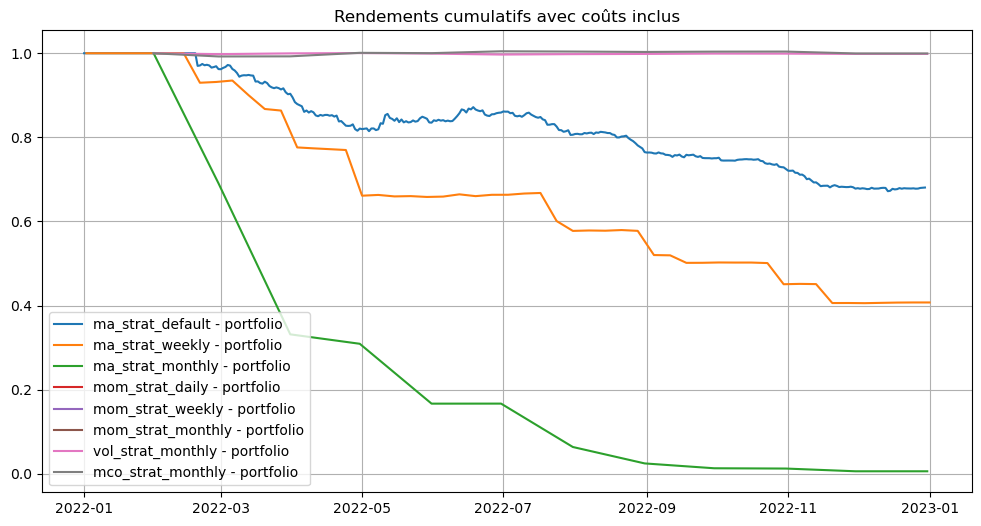

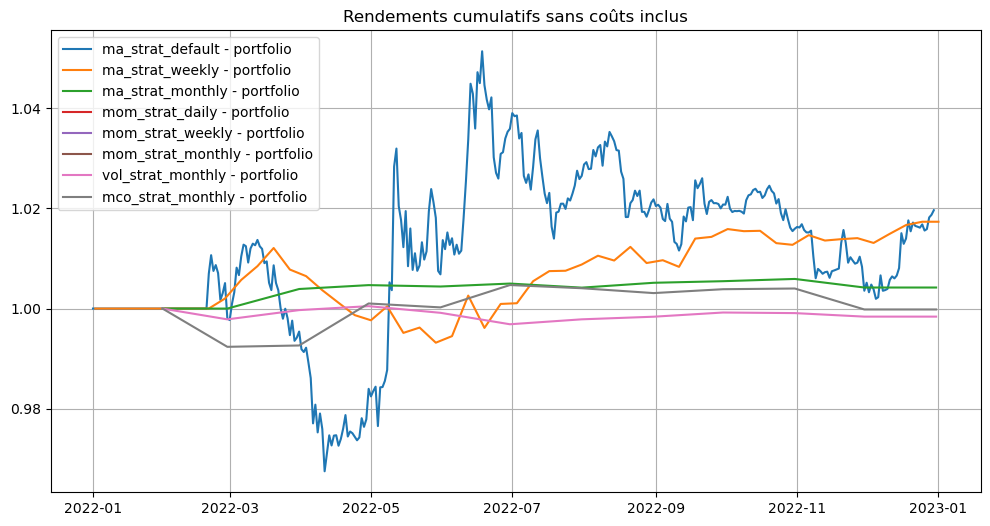

In [4]:

# Visualize results
backend = 'matplotlib' # 'plotly' # 'matplotlib' # 'seaborn'

# Plot individual strategies
manager.plot_all_strategies(backend=backend,include_costs=True)
manager.plot_all_strategies(backend=backend,include_costs=False)


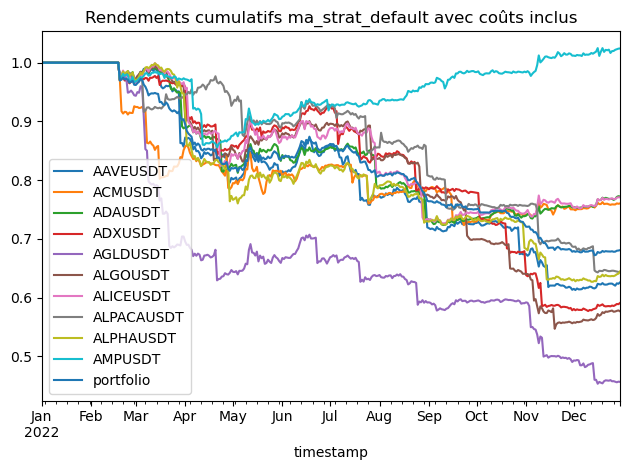

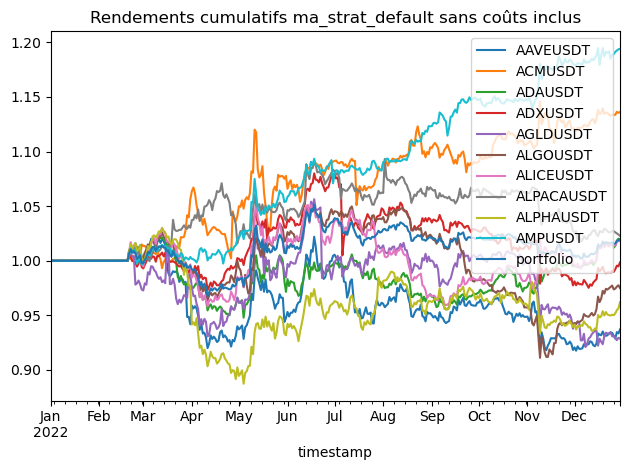

In [5]:

# Plot individual strategies
manager.plot_strategy(strategy_name="ma_strat_default",backend=backend,include_costs=True)
manager.plot_strategy(strategy_name="ma_strat_default",backend=backend,include_costs=False)




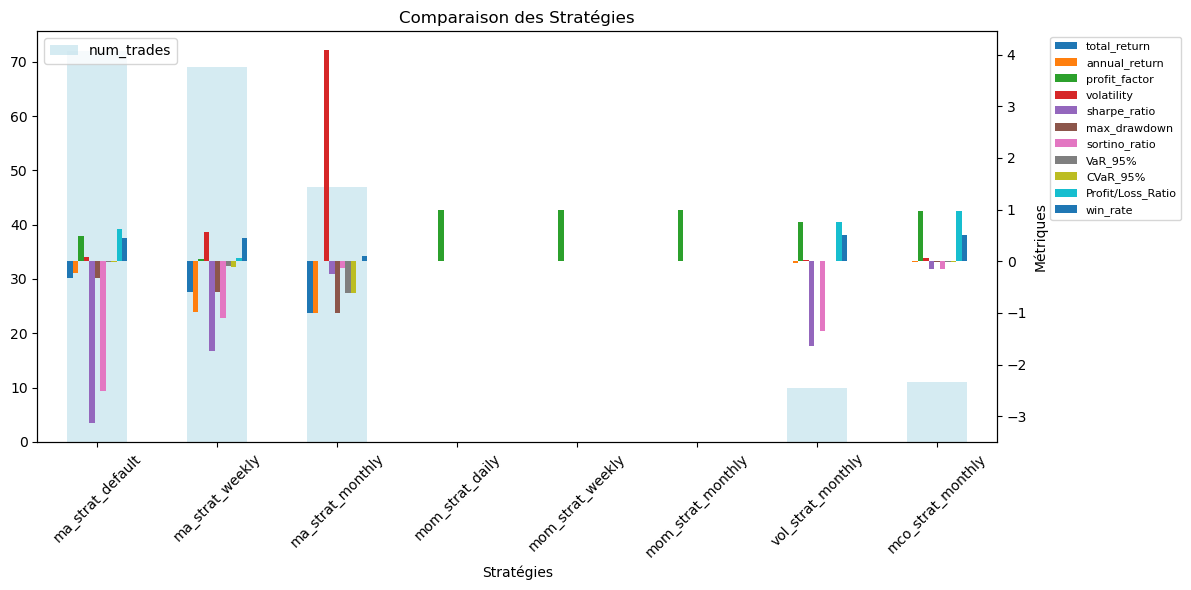

In [6]:

# Compare all strategies
manager.compare_strategies(backend=backend)